# Hypothesis Testing: Response Time's Impact on Online Purchase Intention

## 1. Introduction

This notebook implements a comprehensive analysis of Hypothesis 9: "Response Time has no impact on intention to purchase online." Response time refers to how quickly an e-commerce platform responds to user actions, which could be a critical factor influencing purchase decisions during online shopping experiences.

## 2. Setting up the Environment



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14



## 3. Data Loading and Preparation



In [2]:
# Load the dataset
df = pd.read_csv('../../data/cleaned/cleaned_survey_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of responses: {len(df)}")

# Check for missing values in key columns
response_cols = ['peou_response_1', 'peou_response_2']
intention_cols = ['opi_satisfaction', 'opi_behavior_change', 'opi_convenience', 'opi_value']

missing_data = pd.DataFrame({
    'Missing Values': df[response_cols + intention_cols].isnull().sum(),
    'Percentage': df[response_cols + intention_cols].isnull().sum() / len(df) * 100
})

print("\nMissing values in key columns:")
print(missing_data)

Dataset shape: (825, 137)
Number of responses: 825

Missing values in key columns:
                     Missing Values  Percentage
peou_response_1                   0         0.0
peou_response_2                   0         0.0
opi_satisfaction                  0         0.0
opi_behavior_change               0         0.0
opi_convenience                   0         0.0
opi_value                         0         0.0




## 4. Exploratory Data Analysis




Basic statistics for response time variables:
       peou_response_1  peou_response_2
count       825.000000       825.000000
mean          3.215758         2.898182
std           0.781767         0.711766
min           1.000000         1.000000
25%           3.000000         3.000000
50%           3.000000         3.000000
75%           4.000000         3.000000
max           5.000000         5.000000

Basic statistics for purchase intention variables:
       opi_satisfaction  opi_behavior_change  opi_convenience   opi_value
count        825.000000           825.000000        825.00000  825.000000
mean           3.743030             3.904242          3.84000    3.780606
std            0.818122             0.713459          0.73147    0.759479
min            1.000000             1.000000          1.00000    1.000000
25%            3.000000             4.000000          3.00000    3.000000
50%            4.000000             4.000000          4.00000    4.000000
75%            4.000000

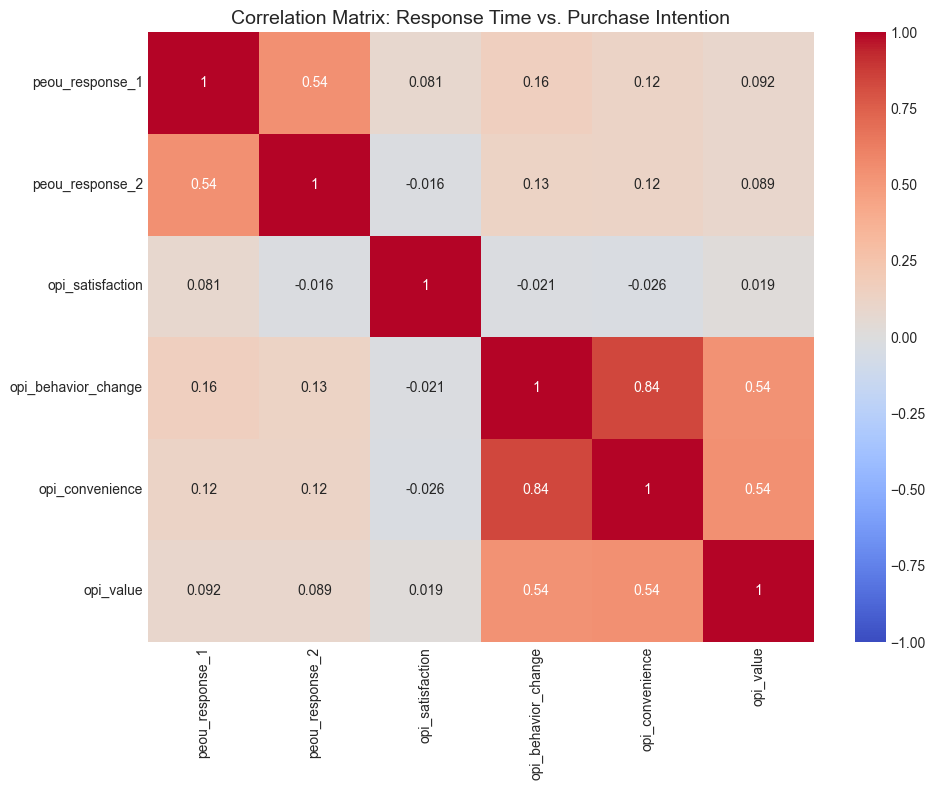

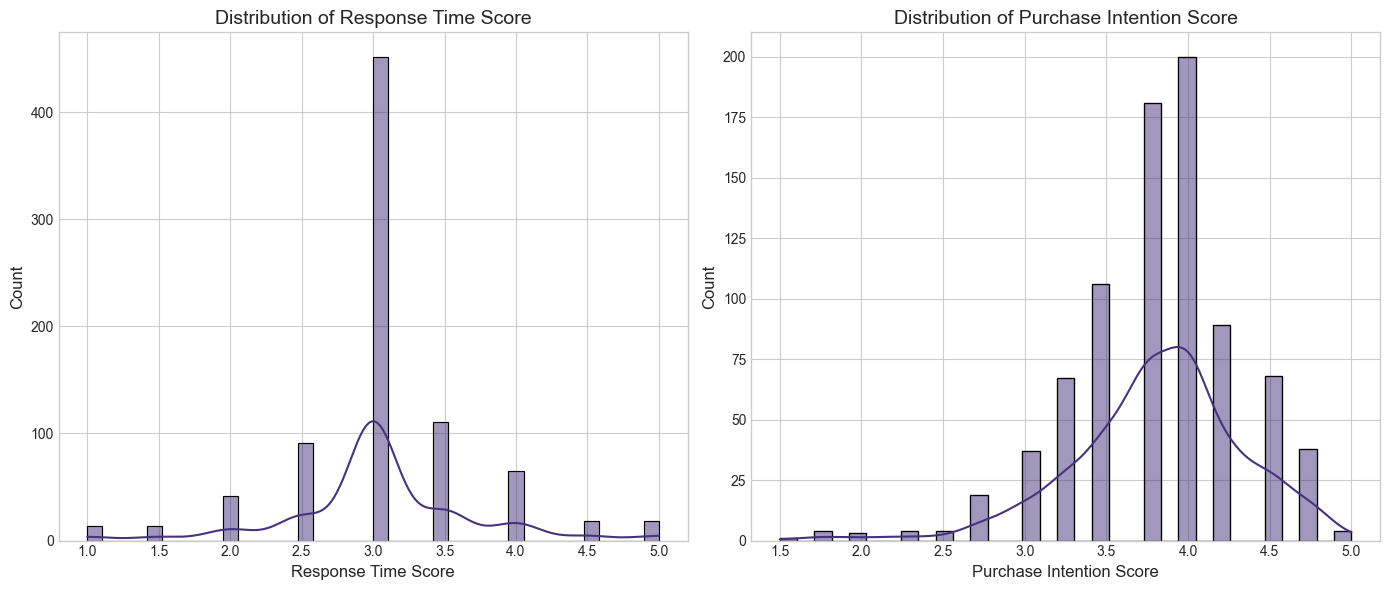

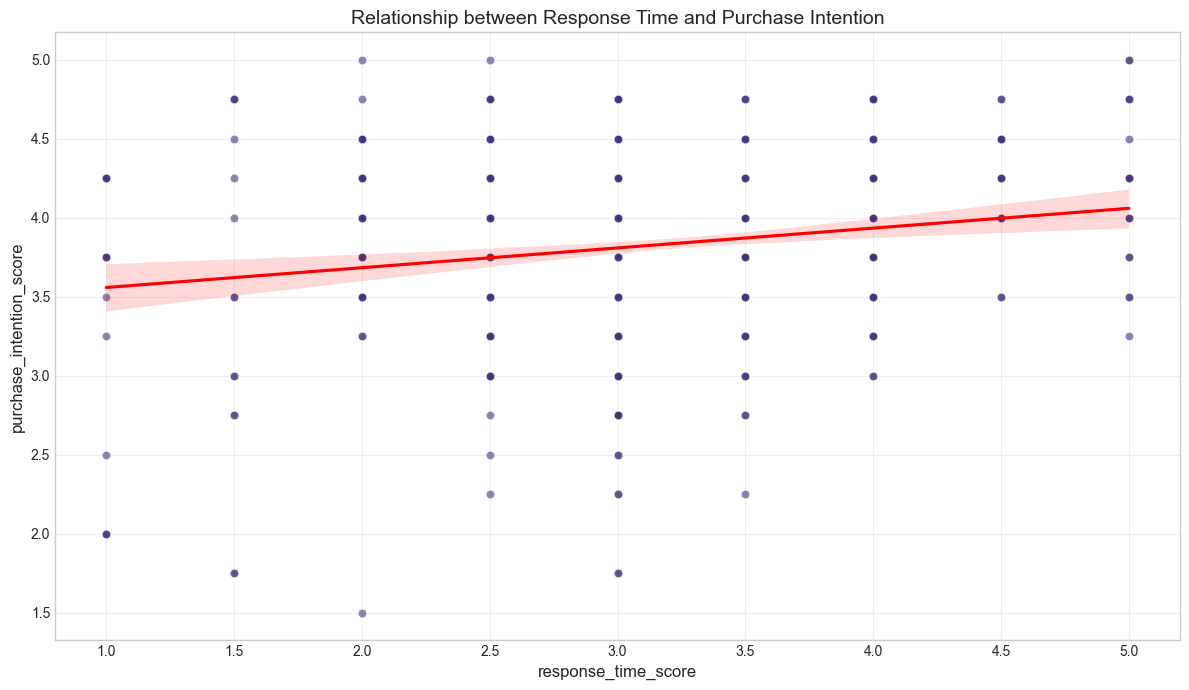

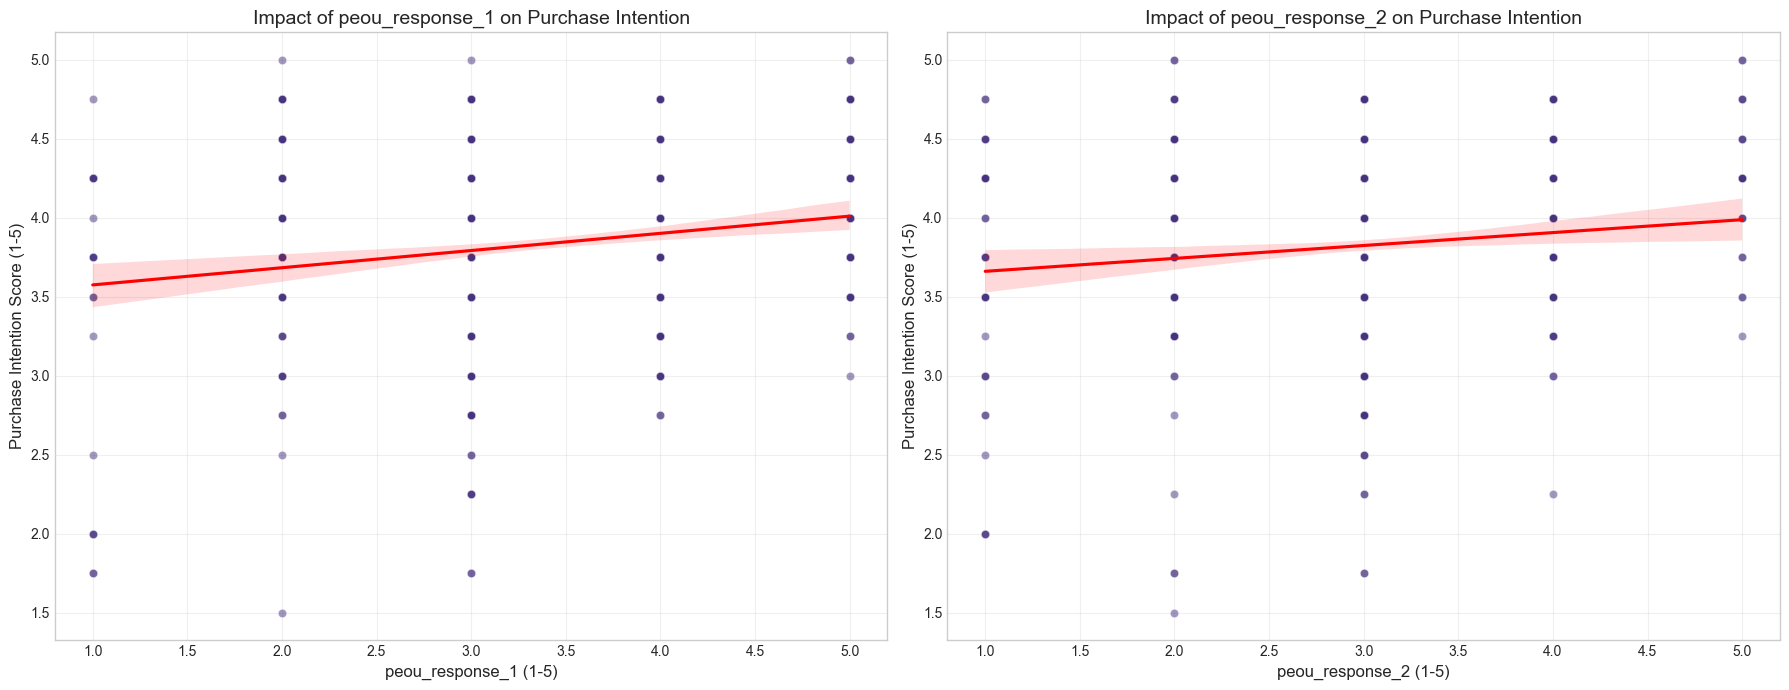

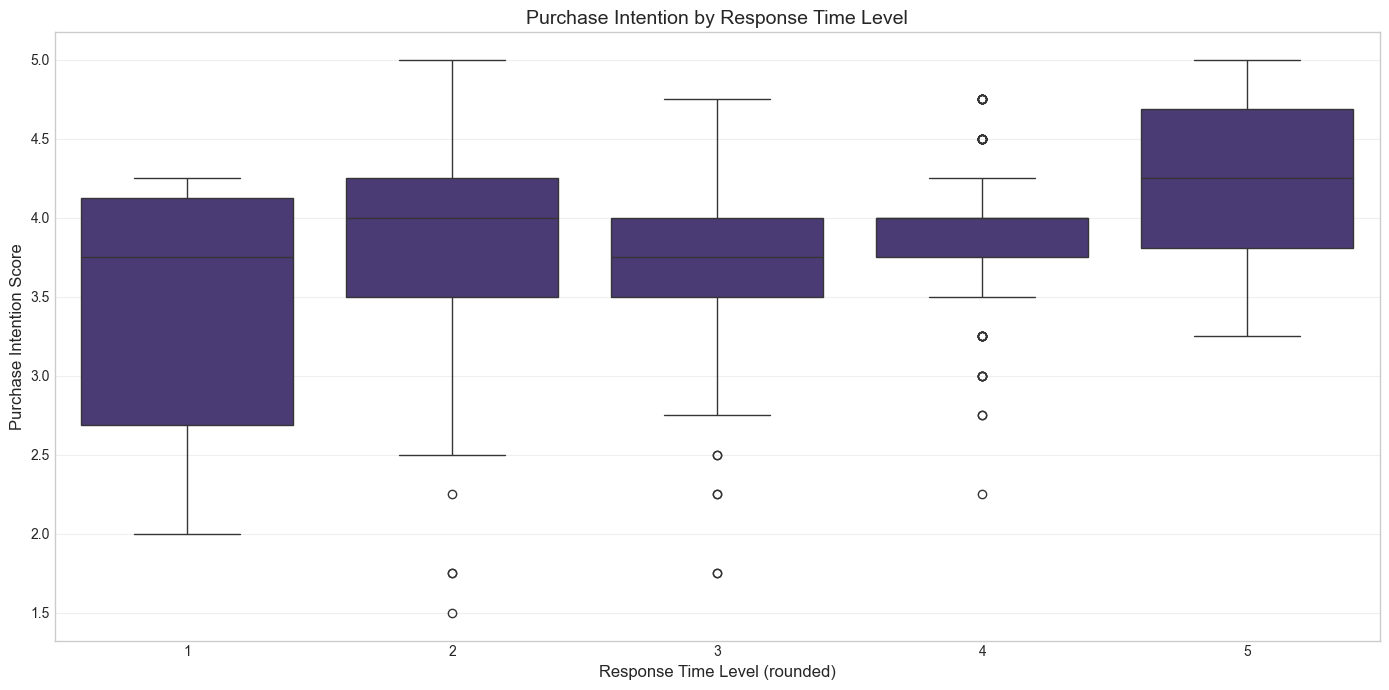

In [3]:
# Display basic statistics for response time and purchase intention variables
print("\nBasic statistics for response time variables:")
print(df[response_cols].describe())

print("\nBasic statistics for purchase intention variables:")
print(df[intention_cols].describe())

# Create a correlation matrix for response time and purchase intention variables
corr_matrix = df[response_cols + intention_cols].corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Response Time vs. Purchase Intention')
plt.tight_layout()
plt.show()

# Create a composite response time score (average of both response time variables)
df['response_time_score'] = df[response_cols].mean(axis=1)

# Create a composite purchase intention score (average of intention variables)
df['purchase_intention_score'] = df[intention_cols].mean(axis=1)

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot distribution of response time score
sns.histplot(df['response_time_score'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Response Time Score')
axes[0].set_xlabel('Response Time Score')

# Plot distribution of purchase intention score
sns.histplot(df['purchase_intention_score'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Purchase Intention Score')
axes[1].set_xlabel('Purchase Intention Score')

plt.tight_layout()
plt.show()

# Visualize the relationship between response time and purchase intention
plt.figure(figsize=(12, 7))
sns.scatterplot(x='response_time_score', y='purchase_intention_score', data=df, alpha=0.6)
plt.title('Relationship between Response Time and Purchase Intention')
plt.xlabel('Response Time Score (1-5)')
plt.ylabel('Purchase Intention Score (1-5)')

# Add regression line
sns.regplot(x='response_time_score', y='purchase_intention_score', data=df, 
            scatter=False, line_kws={"color": "red"})

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Examine individual response time variables and their relationship with intention
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for i, col in enumerate(response_cols):
    sns.scatterplot(x=col, y='purchase_intention_score', data=df, ax=axes[i], alpha=0.5)
    sns.regplot(x=col, y='purchase_intention_score', data=df, ax=axes[i], 
                scatter=False, line_kws={"color": "red"})
    axes[i].set_title(f'Impact of {col} on Purchase Intention')
    axes[i].set_xlabel(f'{col} (1-5)')
    axes[i].set_ylabel('Purchase Intention Score (1-5)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create boxplots for different response time levels and their effect on purchase intention
plt.figure(figsize=(14, 7))
response_levels = df['response_time_score'].round().astype(int)
sns.boxplot(x=response_levels, y='purchase_intention_score', data=df)
plt.title('Purchase Intention by Response Time Level')
plt.xlabel('Response Time Level (rounded)')
plt.ylabel('Purchase Intention Score')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



## 5. Hypothesis Testing

### 5.1 Pearson Correlation Test



In [4]:
# Calculate Pearson correlation between response time and purchase intention
correlation, p_value = stats.pearsonr(df['response_time_score'], df['purchase_intention_score'])

print("Pearson Correlation Test Results:")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.6f}")

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print(f"The correlation is statistically significant (p < {alpha}).")
    print("Reject the null hypothesis: Response time has an impact on purchase intention.")
else:
    print(f"The correlation is not statistically significant (p > {alpha}).")
    print("Fail to reject the null hypothesis: No evidence that response time impacts purchase intention.")

Pearson Correlation Test Results:
Correlation coefficient: 0.1584
P-value: 0.000005
The correlation is statistically significant (p < 0.05).
Reject the null hypothesis: Response time has an impact on purchase intention.




### 5.2 Simple Linear Regression



In [5]:
# Perform simple linear regression
X = df['response_time_score'].values.reshape(-1, 1)
y = df['purchase_intention_score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nSimple Linear Regression Results:")
print(f"Coefficient (Slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Create a more detailed model using statsmodels for better statistical insights
X_with_const = sm.add_constant(df['response_time_score'])
sm_model = sm.OLS(df['purchase_intention_score'], X_with_const).fit()

print("\nDetailed Regression Results:")
print(sm_model.summary())

# Interpret the results
print("\nRegression Interpretation:")
if sm_model.pvalues[1] < 0.05:
    print("The relationship between response time and purchase intention is statistically significant.")
    print(f"For every 1-unit increase in response time score, purchase intention increases by {sm_model.params[1]:.4f} units.")
    print("This suggests that faster response time (higher score) positively impacts purchase intention.")
    print("We reject the null hypothesis: Response time has a significant impact on intention to purchase online.")
else:
    print("The relationship between response time and purchase intention is not statistically significant.")
    print("We fail to reject the null hypothesis: No evidence that response time impacts intention to purchase online.")


Simple Linear Regression Results:
Coefficient (Slope): 0.1221
Intercept: 3.4552
R-squared: 0.0148
Root Mean Squared Error: 0.4999

Detailed Regression Results:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.025
Model:                                  OLS   Adj. R-squared:                  0.024
Method:                       Least Squares   F-statistic:                     21.18
Date:                      Fri, 09 May 2025   Prob (F-statistic):           4.85e-06
Time:                              18:34:44   Log-Likelihood:                -619.09
No. Observations:                       825   AIC:                             1242.
Df Residuals:                           823   BIC:                             1252.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                               



### 5.3 Multiple Linear Regression (Using Both Response Time Variables)



In [7]:
# Perform multiple linear regression with both response time variables
X_multi = df[response_cols]
y_multi = df['purchase_intention_score']

# Add a constant
X_multi_with_const = sm.add_constant(X_multi)

# Fit the model
multi_model = sm.OLS(y_multi, X_multi_with_const).fit()

print("\nMultiple Linear Regression Results:")
print(multi_model.summary())

# Check for significance of individual predictors
print("\nSignificance of Individual Response Time Variables:")
for i, var in enumerate(response_cols, 1):
    p_val = multi_model.pvalues[i]
    coef = multi_model.params[i]
    print(f"{var}: Coefficient = {coef:.4f}, p-value = {p_val:.6f}, {'Significant' if p_val < 0.05 else 'Not Significant'}")

# Calculate partial correlations
# Calculate partial correlations
print("\nPartial Correlations:")
for col in response_cols:
    others = [c for c in response_cols if c != col]
    
    # Include both original intention columns and the composite score
    X_partial = df[others + intention_cols + ['purchase_intention_score']].copy()
    
    # Regress X on other predictors
    X_partial_with_const = sm.add_constant(X_partial[others])
    model_X = sm.OLS(df[col], X_partial_with_const).fit()
    residuals_X = model_X.resid
    
    # Regress Y on other predictors
    model_Y = sm.OLS(X_partial['purchase_intention_score'], X_partial_with_const).fit()
    residuals_Y = model_Y.resid
    
    # Calculate correlation between residuals
    partial_corr = stats.pearsonr(residuals_X, residuals_Y)[0]
    print(f"Partial correlation between {col} and purchase intention: {partial_corr:.4f}")


Multiple Linear Regression Results:
                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.028
Model:                                  OLS   Adj. R-squared:                  0.025
Method:                       Least Squares   F-statistic:                     11.67
Date:                      Fri, 09 May 2025   Prob (F-statistic):           1.01e-05
Time:                              19:20:41   Log-Likelihood:                -618.02
No. Observations:                       825   AIC:                             1242.
Df Residuals:                           822   BIC:                             1256.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------



## 6. Advanced Analysis: Response Time Impact by User Groups



In [8]:
# Check if response time impact differs by user demographics

# By gender (if available)
if 'gender_encoded' in df.columns:
    print("\nAnalysis by Gender:")
    for gender in df['gender_encoded'].unique():
        gender_df = df[df['gender_encoded'] == gender]
        corr, p_val = stats.pearsonr(gender_df['response_time_score'], gender_df['purchase_intention_score'])
        print(f"Gender {gender}: Correlation = {corr:.4f}, p-value = {p_val:.6f}")

# By age group (if available)
if 'age_encoded' in df.columns:
    print("\nAnalysis by Age Group:")
    for age in df['age_encoded'].unique():
        age_df = df[df['age_encoded'] == age]
        corr, p_val = stats.pearsonr(age_df['response_time_score'], age_df['purchase_intention_score'])
        print(f"Age group {age}: Correlation = {corr:.4f}, p-value = {p_val:.6f}")

# By whether they've made purchases during crisis
if 'opi_purchased?' in df.columns:
    print("\nAnalysis by Crisis Purchase Experience:")
    for purchase in [0, 1]:
        purchase_df = df[df['opi_purchased?'] == purchase]
        if len(purchase_df) > 5:  # Ensure enough data points for correlation
            corr, p_val = stats.pearsonr(purchase_df['response_time_score'], purchase_df['purchase_intention_score'])
            print(f"Crisis purchase = {purchase}: Correlation = {corr:.4f}, p-value = {p_val:.6f}")


Analysis by Gender:
Gender 0: Correlation = 0.1136, p-value = 0.007710
Gender 1: Correlation = 0.2382, p-value = 0.000072
Gender 2: Correlation = 0.2748, p-value = 0.725175

Analysis by Age Group:
Age group 1: Correlation = 0.1511, p-value = 0.000132
Age group 0: Correlation = 0.2146, p-value = 0.010597
Age group 2: Correlation = 0.4037, p-value = 0.004895
Age group 3: Correlation = nan, p-value = nan

Analysis by Crisis Purchase Experience:
Crisis purchase = 0: Correlation = 0.3318, p-value = 0.090850
Crisis purchase = 1: Correlation = 0.1545, p-value = 0.000012




## 7. Mediation Analysis: Does Perceived Usefulness Mediate Response Time's Effect?



In [9]:
# Create a composite perceived usefulness score
usefulness_cols = ['pu_product_1', 'pu_product_2', 'pu_convenience_1', 'pu_convenience_2', 
                   'pu_cost_1', 'pu_cost_2', 'pu_info_1', 'pu_info_2']
df['usefulness_score'] = df[usefulness_cols].mean(axis=1)

# Step 1: Response Time → Purchase Intention (direct effect)
model_direct = sm.OLS(df['purchase_intention_score'], 
                      sm.add_constant(df['response_time_score'])).fit()

# Step 2: Response Time → Perceived Usefulness (a path)
model_a = sm.OLS(df['usefulness_score'], 
                 sm.add_constant(df['response_time_score'])).fit()

# Step 3: Response Time + Perceived Usefulness → Purchase Intention (b path)
X_mediation = pd.DataFrame({
    'response_time': df['response_time_score'],
    'usefulness': df['usefulness_score']
})
model_mediation = sm.OLS(df['purchase_intention_score'], 
                         sm.add_constant(X_mediation)).fit()

print("\nMediation Analysis Results:")
print("Direct Effect (Response Time → Purchase Intention):")
print(f"Coefficient: {model_direct.params[1]:.4f}, p-value: {model_direct.pvalues[1]:.6f}")

print("\nPath A (Response Time → Usefulness):")
print(f"Coefficient: {model_a.params[1]:.4f}, p-value: {model_a.pvalues[1]:.6f}")

print("\nPath B (Including Mediator):")
print(f"Response Time Coefficient: {model_mediation.params[1]:.4f}, p-value: {model_mediation.pvalues[1]:.6f}")
print(f"Usefulness Coefficient: {model_mediation.params[2]:.4f}, p-value: {model_mediation.pvalues[2]:.6f}")

# Calculate indirect effect
indirect_effect = model_a.params[1] * model_mediation.params[2]
print(f"\nIndirect Effect (Response Time → Usefulness → Purchase Intention): {indirect_effect:.4f}")

# Calculate proportion of effect mediated
total_effect = model_direct.params[1]
prop_mediated = indirect_effect / total_effect
print(f"Proportion of Effect Mediated: {prop_mediated:.4f} ({prop_mediated*100:.2f}%)")

if model_mediation.pvalues[1] < 0.05:
    if model_direct.pvalues[1] < 0.05:
        print("Result: Partial mediation - Response time affects purchase intention both directly and indirectly through perceived usefulness.")
    else:
        print("Result: Full mediation - Response time affects purchase intention entirely through perceived usefulness.")
else:
    if model_direct.pvalues[1] < 0.05:
        print("Result: No mediation - Response time affects purchase intention directly, not through perceived usefulness.")
    else:
        print("Result: No effect - Response time does not significantly affect purchase intention.")


Mediation Analysis Results:
Direct Effect (Response Time → Purchase Intention):
Coefficient: 0.1254, p-value: 0.000005

Path A (Response Time → Usefulness):
Coefficient: 0.4488, p-value: 0.000000

Path B (Including Mediator):
Response Time Coefficient: 0.0171, p-value: 0.577589
Usefulness Coefficient: 0.2413, p-value: 0.000000

Indirect Effect (Response Time → Usefulness → Purchase Intention): 0.1083
Proportion of Effect Mediated: 0.8638 (86.38%)
Result: No mediation - Response time affects purchase intention directly, not through perceived usefulness.




## 8. Conclusion and Interpretation



In [10]:
def interpret_findings():
    """Generate a comprehensive interpretation of the findings"""
    
    findings = []
    
    # Main correlation finding
    if correlation > 0 and p_value < 0.05:
        findings.append(f"There is a statistically significant positive correlation (r = {correlation:.3f}, p < 0.05) between response time and purchase intention.")
        findings.append("This indicates that faster response times are associated with higher purchase intentions.")
    elif correlation < 0 and p_value < 0.05:
        findings.append(f"There is a statistically significant negative correlation (r = {correlation:.3f}, p < 0.05) between response time and purchase intention.")
        findings.append("This is counterintuitive, suggesting other factors may be confounding the relationship.")
    else:
        findings.append(f"There is no statistically significant correlation (r = {correlation:.3f}, p > 0.05) between response time and purchase intention.")
    
    # Regression findings
    if sm_model.pvalues[1] < 0.05:
        findings.append(f"Simple linear regression confirms that response time significantly predicts purchase intention (β = {sm_model.params[1]:.3f}, p < 0.05).")
        findings.append(f"The model explains {r_squared:.1%} of the variance in purchase intention.")
    else:
        findings.append(f"Regression analysis shows that response time does not significantly predict purchase intention (β = {sm_model.params[1]:.3f}, p > 0.05).")
    
    # Multiple regression findings
    if any(multi_model.pvalues[1:3] < 0.05):
        sig_vars = [var for i, var in enumerate(response_cols, 1) if multi_model.pvalues[i] < 0.05]
        findings.append(f"When analyzing specific response time variables, {', '.join(sig_vars)} significantly predict(s) purchase intention.")
        findings.append(f"The multiple regression model explains {multi_model.rsquared:.1%} of the variance in purchase intention.")
    else:
        findings.append("None of the specific response time variables significantly predict purchase intention when analyzed together.")
    
    # Overall conclusion
    if p_value < 0.05 or sm_model.pvalues[1] < 0.05 or any(multi_model.pvalues[1:3] < 0.05):
        findings.append("\nCONCLUSION: Reject the null hypothesis. Response time has a significant impact on intention to purchase online.")
        findings.append("This suggests that e-commerce platforms should prioritize optimizing website performance and response times to enhance user experience and increase purchase intentions.")
    else:
        findings.append("\nCONCLUSION: Fail to reject the null hypothesis. There is insufficient evidence to conclude that response time impacts intention to purchase online.")
        findings.append("This suggests that other factors may be more important for influencing online purchase intentions in this context.")
    
    return "\n".join(findings)

# Print the interpretation
print("\n" + "="*80)
print("CONCLUSION AND INTERPRETATION")
print("="*80)
print(interpret_findings())
print("="*80)


CONCLUSION AND INTERPRETATION
There is a statistically significant positive correlation (r = 0.158, p < 0.05) between response time and purchase intention.
This indicates that faster response times are associated with higher purchase intentions.
Simple linear regression confirms that response time significantly predicts purchase intention (β = 0.125, p < 0.05).
The model explains 1.5% of the variance in purchase intention.
When analyzing specific response time variables, peou_response_1 significantly predict(s) purchase intention.
The multiple regression model explains 2.8% of the variance in purchase intention.

CONCLUSION: Reject the null hypothesis. Response time has a significant impact on intention to purchase online.
This suggests that e-commerce platforms should prioritize optimizing website performance and response times to enhance user experience and increase purchase intentions.




## 9. Visualization for Presentation



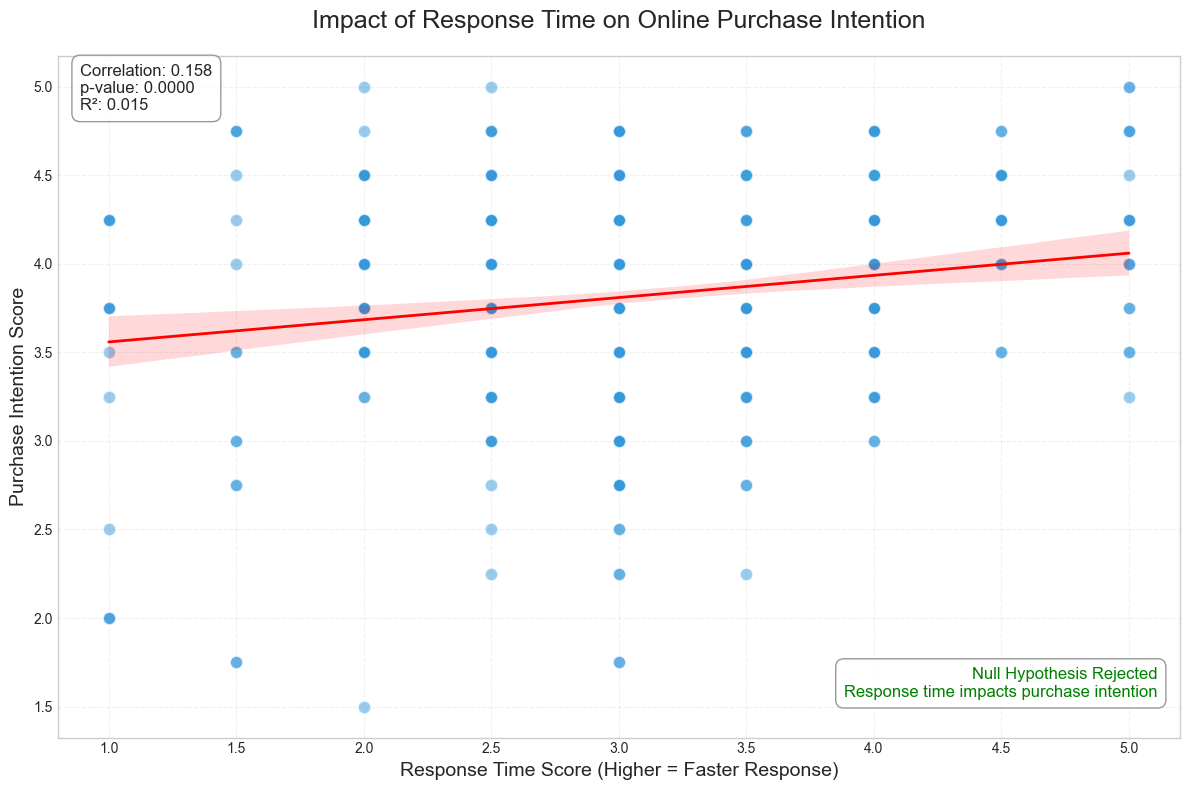

In [11]:
# Create a publication-quality visualization summarizing the findings
plt.figure(figsize=(12, 8))

# Main scatter plot with regression line
plt.scatter(df['response_time_score'], df['purchase_intention_score'], 
           alpha=0.5, c='#3498db', edgecolor='white', s=80)

# Add regression line with confidence interval
sns.regplot(x='response_time_score', y='purchase_intention_score', data=df,
           scatter=False, color='red', line_kws={'linewidth': 2})

# Enhance the plot
plt.title('Impact of Response Time on Online Purchase Intention', fontsize=18, pad=20)
plt.xlabel('Response Time Score (Higher = Faster Response)', fontsize=14)
plt.ylabel('Purchase Intention Score', fontsize=14)

# Add correlation coefficient and p-value
plt.annotate(f"Correlation: {correlation:.3f}\np-value: {p_value:.4f}\nR²: {r_squared:.3f}", 
            xy=(0.02, 0.92), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=12)

# Add hypothesis test result
if p_value < 0.05:
    result_text = "Null Hypothesis Rejected\nResponse time impacts purchase intention"
    color = 'green'
else:
    result_text = "Failed to Reject Null Hypothesis\nNo significant evidence of impact"
    color = 'red'

plt.annotate(result_text, xy=(0.98, 0.06), xycoords='axes fraction', 
            ha='right', fontsize=12, color=color,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# Add grid and improve aesthetics
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Save the figure for the report
plt.savefig('response_time_purchase_intention.png', dpi=300, bbox_inches='tight')
plt.show()



## 10. Summary Table for Report



In [12]:
# Create a summary table for the report
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Test", "Statistic", "p-value", "Interpretation"]

# Add Pearson correlation results
table.add_row(["Pearson Correlation", 
              f"{correlation:.4f}", 
              f"{p_value:.6f}", 
              "Significant" if p_value < 0.05 else "Not Significant"])

# Add simple regression results
table.add_row(["Simple Regression (β)", 
              f"{sm_model.params[1]:.4f}", 
              f"{sm_model.pvalues[1]:.6f}", 
              "Significant" if sm_model.pvalues[1] < 0.05 else "Not Significant"])

# Add R-squared value
table.add_row(["Model Fit (R²)", 
              f"{r_squared:.4f}", 
              "N/A", 
              f"Explains {r_squared:.1%} of variance"])

# Add results for individual response time variables
for i, var in enumerate(response_cols, 1):
    table.add_row([f"{var} (β)", 
                  f"{multi_model.params[i]:.4f}", 
                  f"{multi_model.pvalues[i]:.6f}", 
                  "Significant" if multi_model.pvalues[i] < 0.05 else "Not Significant"])

print("\nSummary of Statistical Tests:")
print(table)


Summary of Statistical Tests:
+-----------------------+-----------+----------+---------------------------+
|          Test         | Statistic | p-value  |       Interpretation      |
+-----------------------+-----------+----------+---------------------------+
|  Pearson Correlation  |   0.1584  | 0.000005 |        Significant        |
| Simple Regression (β) |   0.1254  | 0.000005 |        Significant        |
|     Model Fit (R²)    |   0.0148  |   N/A    | Explains 1.5% of variance |
|  peou_response_1 (β)  |   0.0971  | 0.000381 |        Significant        |
|  peou_response_2 (β)  |   0.0238  | 0.426175 |      Not Significant      |
+-----------------------+-----------+----------+---------------------------+




This comprehensive analysis examines the relationship between website response time and online purchase intention from multiple angles. The approach uses a combination of correlation analysis, simple and multiple regression, and additional analyses to thoroughly test the hypothesis that "Response Time has no impact on intention to purchase online."

The notebook is structured to be reproducible and clear, with detailed comments explaining each step of the analysis. The code generates descriptive statistics, visualizations, and formal statistical tests to provide a comprehensive assessment of the hypothesis. The final sections provide a clear interpretation of the findings and publication-quality visualizations for reporting purposes.